# Rain or shine: What drives bike share hourly usage?

You are provided hourly rental data spanning two years. For this competition, the training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month. You must predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period. 

The dataset is not huge as there are about 10,866 records and 12 columns in the training data, so I will plan on testing linear regression, decision tree, random forest, xg booster as well as a ensembling techniques using the aforementioned models like voting_regressor and stack_regressor.

* datetime - hourly date + timestamp  
* season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
* holiday - whether the day is considered a holiday
* workingday - whether the day is neither a weekend nor holiday
* weather - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
* temp - temperature in Celsius
* atemp - "feels like" temperature in Celsius
* humidity - relative humidity
* windspeed - wind speed
* casual - number of non-registered user rentals initiated
* registered - number of registered user rentals initiated
* count - number of total rentals

Data is from Capital Bike share in Washington DC provided through a Kaggle competition found here: https://www.kaggle.com/c/bike-sharing-demand/data

The evaluation metric for this competition is Root Mean Squared Logarithmic Error (RMSLE). My goal is to create a model to get into the top 20% of predictions, which would be a RMSLE of 0.43304 or better. 

In [453]:
#Import required libraries
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os
import pandas as pd
from math import sqrt

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "unsupervised_learning"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Get the data

In [454]:
train = pd.read_csv("datasets/bikes/train.csv")
test = pd.read_csv("datasets/bikes/test.csv")
print("Train: ", train.shape)
print("Test: ", test.shape)

Train:  (10886, 12)
Test:  (6493, 9)


In [455]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [456]:
#I'm going to combine test and train data briefly while I do data cleaning and feature engineering, then I'll split it back apart
data = pd.concat([train, test], sort=False)
data = data.reset_index(drop=True)
data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3.0,13.0,16.0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8.0,32.0,40.0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5.0,27.0,32.0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3.0,10.0,13.0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0.0,1.0,1.0


In [457]:
data.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,10886.000000,10886.000000,10886.000000
mean,2.501640,0.028770,0.682721,1.425283,20.376474,23.788755,62.722884,12.736540,36.021955,155.552177,191.574132
std,1.106918,0.167165,0.465431,0.639357,7.894801,8.592511,19.292983,8.196795,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.820000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.940000,16.665000,48.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.500000,24.240000,63.000000,12.998000,17.000000,118.000000,145.000000
75%,3.000000,0.000000,1.000000,2.000000,27.060000,31.060000,78.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.000000,50.000000,100.000000,56.996900,367.000000,886.000000,977.000000


In [458]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 12 columns):
datetime      17379 non-null object
season        17379 non-null int64
holiday       17379 non-null int64
workingday    17379 non-null int64
weather       17379 non-null int64
temp          17379 non-null float64
atemp         17379 non-null float64
humidity      17379 non-null int64
windspeed     17379 non-null float64
casual        10886 non-null float64
registered    10886 non-null float64
count         10886 non-null float64
dtypes: float64(6), int64(5), object(1)
memory usage: 1.6+ MB


Great news! No missing data.

In [459]:
y_train_data = train["count"]
y_casual = train["casual"]
y_registered = train["registered"]

In [460]:
#Feature engineering for dates
data["hour"] = [t.hour for t in pd.DatetimeIndex(data.datetime)]
data["day"] = [t.dayofweek for t in pd.DatetimeIndex(data.datetime)]
data["month"] = [t.month for t in pd.DatetimeIndex(data.datetime)]
data['year'] = [t.year for t in pd.DatetimeIndex(data.datetime)]
data['year'] = data['year'].map({2011:0, 2012:1})

In [461]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 16 columns):
datetime      17379 non-null object
season        17379 non-null int64
holiday       17379 non-null int64
workingday    17379 non-null int64
weather       17379 non-null int64
temp          17379 non-null float64
atemp         17379 non-null float64
humidity      17379 non-null int64
windspeed     17379 non-null float64
casual        10886 non-null float64
registered    10886 non-null float64
count         10886 non-null float64
hour          17379 non-null int64
day           17379 non-null int64
month         17379 non-null int64
year          17379 non-null int64
dtypes: float64(6), int64(9), object(1)
memory usage: 2.1+ MB


# Explore the data

In [462]:
data.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,day,month,year
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,10886.000000,10886.000000,10886.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,2.501640,0.028770,0.682721,1.425283,20.376474,23.788755,62.722884,12.736540,36.021955,155.552177,191.574132,11.546752,3.011451,6.537775,0.502561
std,1.106918,0.167165,0.465431,0.639357,7.894801,8.592511,19.292983,8.196795,49.960477,151.039033,181.144454,6.914405,2.001966,3.438776,0.500008
min,1.000000,0.000000,0.000000,1.000000,0.820000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,13.940000,16.665000,48.000000,7.001500,4.000000,36.000000,42.000000,6.000000,1.000000,4.000000,0.000000
50%,3.000000,0.000000,1.000000,1.000000,20.500000,24.240000,63.000000,12.998000,17.000000,118.000000,145.000000,12.000000,3.000000,7.000000,1.000000
75%,3.000000,0.000000,1.000000,2.000000,27.060000,31.060000,78.000000,16.997900,49.000000,222.000000,284.000000,18.000000,5.000000,10.000000,1.000000
max,4.000000,1.000000,1.000000,4.000000,41.000000,50.000000,100.000000,56.996900,367.000000,886.000000,977.000000,23.000000,6.000000,12.000000,1.000000


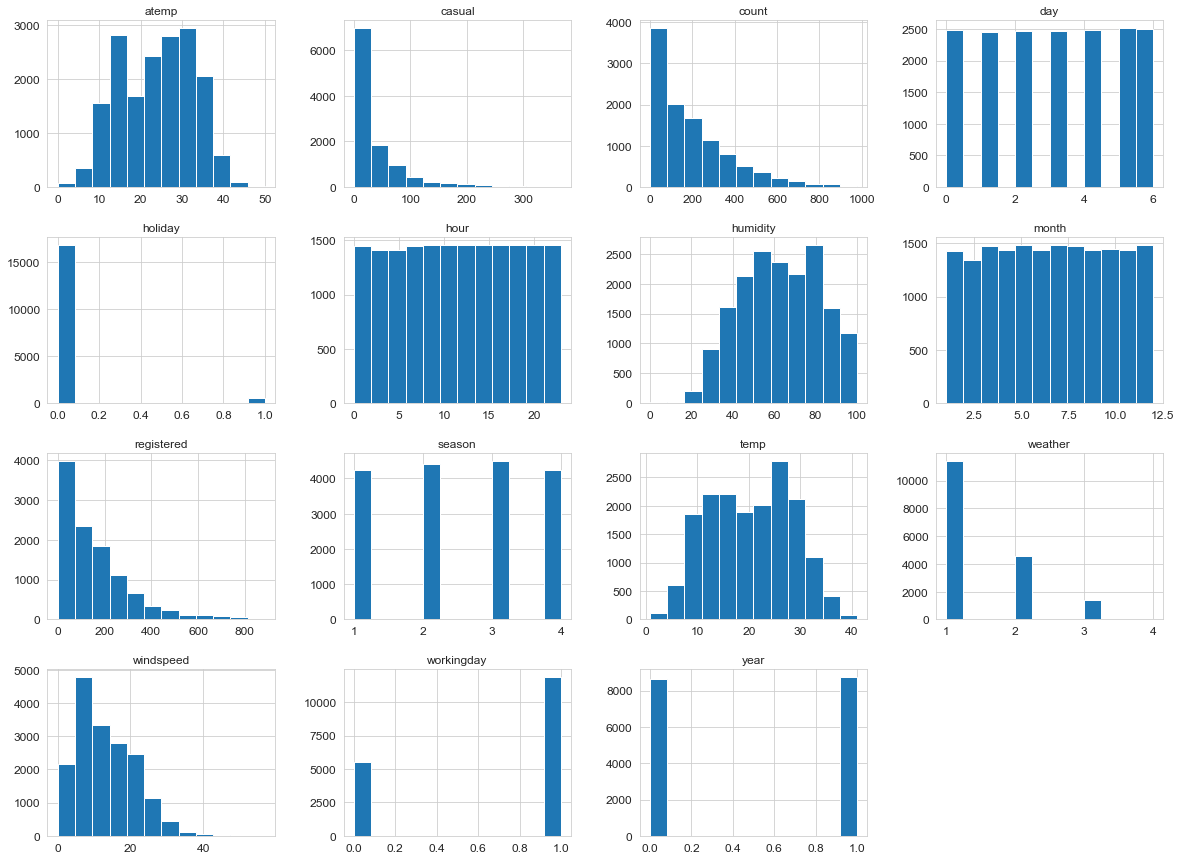

In [463]:
%matplotlib inline
import matplotlib.pyplot as plt
data.hist(bins=12, figsize=(20,15))
#save_fig("attribute_histogram_plots")
plt.show()

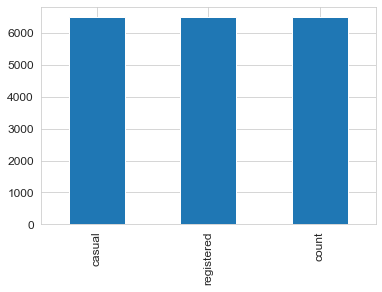

In [464]:
import seaborn as sns
sns.set_style("whitegrid")
missing = data.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

It makes sense that the y_values are missing from the testset, otherwise this would be pretty easy.

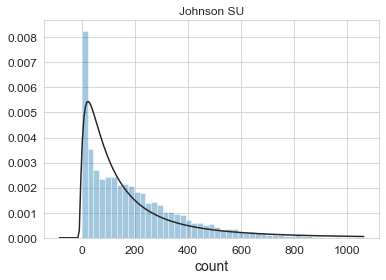

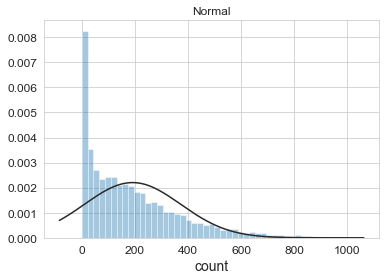

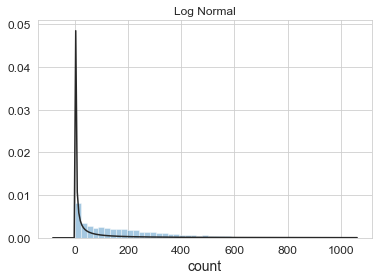

In [465]:
import scipy.stats as stats
y = train['count']
plt.figure(1); plt.title('Johnson SU')
sns.distplot(y, kde=False, fit=stats.johnsonsu)
plt.figure(2); plt.title('Normal')
sns.distplot(y, kde=False, fit=stats.norm)
plt.figure(3); plt.title('Log Normal')
sns.distplot(y, kde=False, fit=stats.lognorm)

Looks like distribution is the right side of the normal distribution.

In [466]:
corr_matrix = data.corr()

In [467]:
corr_matrix["count"].sort_values(ascending=False)

count         1.000000
registered    0.970948
casual        0.690414
hour          0.400601
temp          0.394454
atemp         0.389784
year          0.260403
month         0.166862
season        0.163439
windspeed     0.101369
workingday    0.011594
day          -0.002283
holiday      -0.005393
weather      -0.128655
humidity     -0.317371
Name: count, dtype: float64

In [468]:
corr_matrix["registered"].sort_values(ascending=False)

registered    1.000000
count         0.970948
casual        0.497250
hour          0.380540
temp          0.318571
atemp         0.314635
year          0.264265
month         0.169451
season        0.164011
workingday    0.119460
windspeed     0.091052
holiday      -0.020956
day          -0.084427
weather      -0.109340
humidity     -0.265458
Name: registered, dtype: float64

In [469]:
corr_matrix["casual"].sort_values(ascending=False)

casual        1.000000
count         0.690414
registered    0.497250
temp          0.467097
atemp         0.462067
hour          0.302045
day           0.246959
year          0.145241
season        0.096758
month         0.092722
windspeed     0.092276
holiday       0.043799
weather      -0.135918
workingday   -0.319111
humidity     -0.348187
Name: casual, dtype: float64

Obviously high correlation between the y_values of count, registered, and casual. Temperature and atemp are the next highest factors. People prefer to ride when it's not freezing cold I imagine. The impact of year may be because we only have 2 years of data and the user base was growing during that time. No real surprises here.

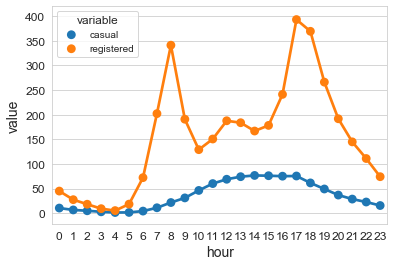

In [470]:
hourTransformed = pd.melt(data[["hour","casual","registered"]], id_vars=['hour'], value_vars=['casual', 'registered'])
hourAggregated = pd.DataFrame(hourTransformed.groupby(["hour","variable"],sort=True)["value"].mean()).reset_index()
sns.pointplot(x=hourAggregated["hour"], y=hourAggregated["value"],hue=hourAggregated["variable"],hue_order=["casual","registered"], data=hourAggregated, join=True)

While I could develop a model for casual and a model for registered and then combine them to get my prediction for count, that sounds like a lot of work and based on above graph, it doesn't look like it would be a materially better model than using the combined numbers because the distribution of casual is so normal. 

In [471]:
#Drop columns if needed
data.drop("count", axis=1, inplace=True)
data.drop("casual", axis=1, inplace=True)
data.drop("registered", axis=1, inplace=True)
data.drop("datetime", axis=1, inplace=True)

In [472]:
data.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour,day,month,year
0,1,0,0,1,9.84,14.395,81,0.0,0,5,1,0
1,1,0,0,1,9.02,13.635,80,0.0,1,5,1,0
2,1,0,0,1,9.02,13.635,80,0.0,2,5,1,0
3,1,0,0,1,9.84,14.395,75,0.0,3,5,1,0
4,1,0,0,1,9.84,14.395,75,0.0,4,5,1,0


# Prepare the data

In [473]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

## Numeric columns

In [474]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
num_columns = ['temp', 'atemp', 'humidity', 'windspeed', 'hour']

num_pipeline = Pipeline([
        ("select_numeric", DataFrameSelector(num_columns)),
        ("imputer", SimpleImputer(strategy="median")),
    ])

In [475]:
num_pipeline.fit_transform(data)

array([[ 9.84  , 14.395 , 81.    ,  0.    ,  0.    ],
       [ 9.02  , 13.635 , 80.    ,  0.    ,  1.    ],
       [ 9.02  , 13.635 , 80.    ,  0.    ,  2.    ],
       ...,
       [10.66  , 12.88  , 60.    , 11.0014, 21.    ],
       [10.66  , 13.635 , 56.    ,  8.9981, 22.    ],
       [10.66  , 13.635 , 65.    ,  8.9981, 23.    ]])

In [476]:
# Inspired from stackoverflow.com/questions/25239958
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

## Categorical columns

In [477]:
from sklearn.preprocessing import OneHotEncoder

In [478]:
cat_columns = ['season', 'holiday', 'workingday', 'weather', 'month', 'day', 'year']

cat_pipeline = Pipeline([
        ("select_cat", DataFrameSelector(cat_columns)),
        ("imputer", MostFrequentImputer()),
        ("cat_encoder", OneHotEncoder(sparse=False)),
    ])

In [479]:
cat_pipeline.fit_transform(data)

C:\Users\Taylor\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


array([[1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 1.]])

In [480]:
from sklearn.pipeline import FeatureUnion
preprocess_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [481]:
X_data = preprocess_pipeline.fit_transform(data)
X_data.shape

C:\Users\Taylor\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


(17379, 38)

In [482]:
X_train, X_test = X_data[:len(train)], X_data[len(train):]

In [483]:
# Test split
print("train_data: ", X_train.shape)
print("Train: ", train.shape)
print("test_data: ", X_test.shape)
print("Test: ", test.shape)

train_data:  (10886, 38)
Train:  (10886, 12)
test_data:  (6493, 38)
Test:  (6493, 9)


In [484]:
y_train_data.shape

(10886,)

In [485]:
#Train / Vaidation Split
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_data, y_train_data, test_size=0.2, random_state=42)
# Test split
print("X_train: ", X_train.shape)
print("X_val: ", X_val.shape)
print("y_train: ", y_train.shape)
print("y_val: ", y_val.shape)

X_train:  (8708, 38)
X_val:  (2178, 38)
y_train:  (8708,)
y_val:  (2178,)


# Shortlist promising models

In [486]:
#Function to automate calculating metrics
def rmse_score(y_train, pred):
    rmsle = sqrt(sklearn.metrics.mean_squared_error(np.log(y_train), np.log(pred)))
    rmse = sqrt(sklearn.metrics.mean_squared_error(y_train, pred))
    print("RMSE", rmse)
    print("RMSLE", rmsle)

## Linear Regression

In [487]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()

In [488]:
lin_reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [489]:
lin_pred_train = lin_reg.predict(X_train)
lin_pred = lin_reg.predict(X_val)
lin_rmse = sqrt(sklearn.metrics.mean_squared_error(y_val, lin_pred))
print("lin_pred", rmse)

lin_pred 36.29818646977678


In [490]:
cols = ['temp', 'atemp', 'humidity', 'windspeed', 'hour', #5
        'season1', 'season2', 'season3', 'season4', #4
        'holiday0', 'holiday1', #2
        'workingday0', 'workingday1', #2 
        'weather1', 'weather2', 'weather3', 'weather4', #4
        'jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec', #12
        'day1', 'day2', 'day3', 'day4', 'day5', 'day6', 'day7', #7 
        'year_2011', 'year_2012'] #2

In [491]:
coeff_df = pd.DataFrame(lin_reg.coef_, cols)
coeff_df

,0
temp,7.100760e+00
atemp,2.068199e+00
humidity,-1.982987e+00
windspeed,3.188036e-01
hour,7.510165e+00
season1,1.131897e+12
season2,1.390935e+12
season3,2.747943e+12
season4,1.375921e+12
holiday0,-2.534644e+09


Looks like linear regression couldn't figure out a linear way to model the hour, which caused its coefficient to drop lower than I would have expected.

## Tree Regression

In [492]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor(random_state=42,max_depth = 100)

In [493]:
tree_reg.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=100, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')

In [494]:
tree_pred_train = tree_reg.predict(X_train)
tree_pred = tree_reg.predict(X_val)
rmse_score(y_val, tree_pred)
tree_rmse = sqrt(sklearn.metrics.mean_squared_error(y_val, tree_pred))

RMSE 57.93845488651973
RMSLE 0.4628169030494486


In [324]:
#Score: 0.43024

### Tree intepretation

[Text(620.0, 652.3199999999999, 'hour <= 6.0\nmse = 32761.0\nsamples = 8708\nvalue = 192.0'),
 Text(310.0, 507.36, 'hour <= 6.0\nmse = 1525.0\nsamples = 2514\nvalue = 33.0'),
 Text(155.0, 362.4, 'hour <= 0.0\nmse = 893.0\nsamples = 2154\nvalue = 25.0'),
 Text(77.5, 217.44000000000005, 'workingday1 <= 0.0\nmse = 1672.0\nsamples = 371\nvalue = 54.0'),
 Text(38.75, 72.48000000000002, '\n  (...)  \n'),
 Text(116.25, 72.48000000000002, '\n  (...)  \n'),
 Text(232.5, 217.44000000000005, 'workingday1 <= 0.0\nmse = 515.0\nsamples = 1783\nvalue = 19.0'),
 Text(193.75, 72.48000000000002, '\n  (...)  \n'),
 Text(271.25, 72.48000000000002, '\n  (...)  \n'),
 Text(465.0, 362.4, 'workingday0 <= 0.0\nmse = 2951.0\nsamples = 360\nvalue = 78.0'),
 Text(387.5, 217.44000000000005, 'year_2011 <= 0.0\nmse = 2046.0\nsamples = 251\nvalue = 102.0'),
 Text(348.75, 72.48000000000002, '\n  (...)  \n'),
 Text(426.25, 72.48000000000002, '\n  (...)  \n'),
 Text(542.5, 217.44000000000005, 'holiday0 <= 0.0\nmse = 323

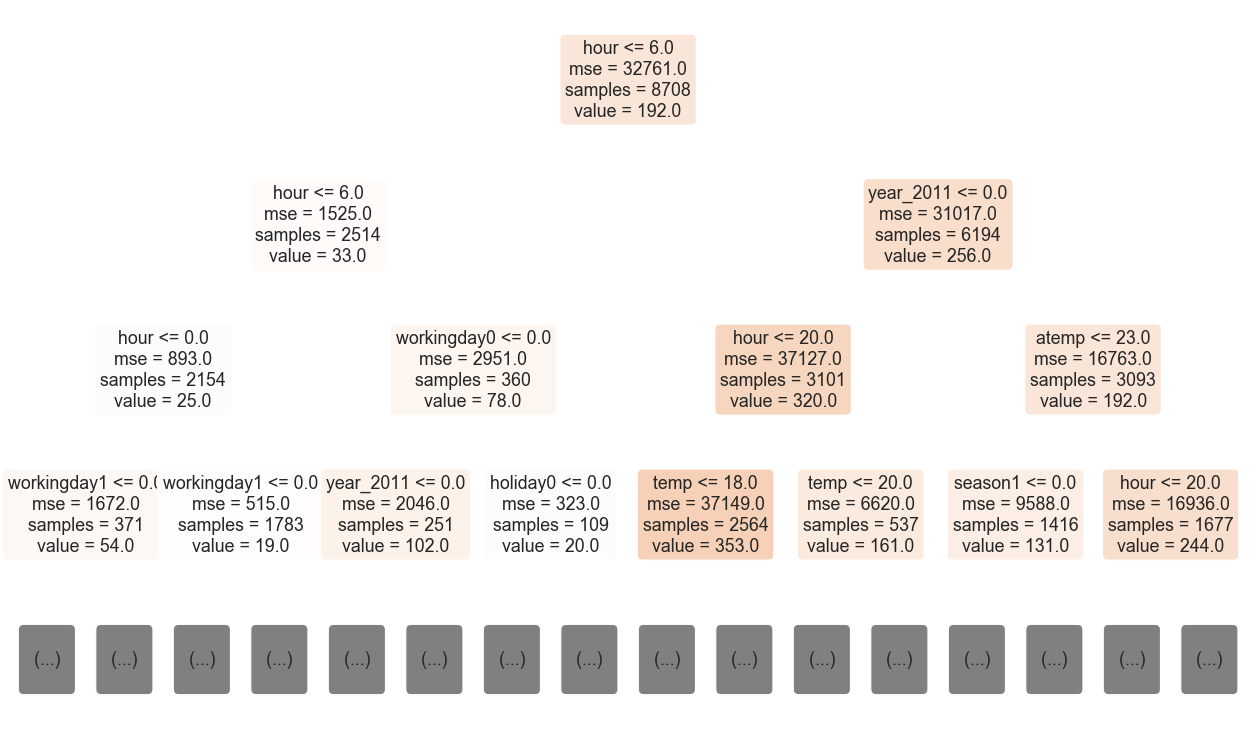

In [495]:
#https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html#sklearn.tree.plot_tree
from matplotlib.pyplot import figure
figure(num=None, figsize=(20, 12), dpi=80, facecolor='w', edgecolor='k')
sklearn.tree.plot_tree(tree_reg, max_depth=3, feature_names=cols, class_names=None, label='all', filled=True, impurity=True, node_ids=False, proportion=False, rotate=False, rounded=True, precision=0, ax=None, fontsize=16)

## Random forest

In [496]:
from sklearn.ensemble import RandomForestRegressor

rnd_reg = RandomForestRegressor(n_estimators=100, max_leaf_nodes=3000, n_jobs=-1)

In [497]:
rnd_reg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=3000,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

In [498]:
rnd_pred_train = rnd_reg.predict(X_train)
rnd_pred = rnd_reg.predict(X_val)
rmse_score(y_val, rnd_pred)
rnd_rmse = sqrt(sklearn.metrics.mean_squared_error(y_val, rnd_pred))

RMSE 39.37329777672421
RMSLE 0.36785724704603506


In [499]:
rnd_pred = rnd_reg.predict(X_test)
#np.savetxt("bike_pred.csv", rnd_pred, delimiter=",")
#0.56184

In [438]:
feature_importances = rnd_reg.feature_importances_
attributes = num_columns + cat_columns
sorted(zip(feature_importances, attributes), reverse=True)

[(0.600368922091441, 'hour'),
 (0.05918260345776419, 'temp'),
 (0.05080343511173812, 'atemp'),
 (0.038315235150324735, 'year'),
 (0.036285732768061324, 'season'),
 (0.028259409056345757, 'humidity'),
 (0.008840967446258619, 'windspeed'),
 (0.0020941593283677245, 'weather'),
 (0.0011685945649244258, 'holiday'),
 (0.0008387161368317102, 'workingday'),
 (0.0007374088647714321, 'day'),
 (0.0005659526833061902, 'month')]

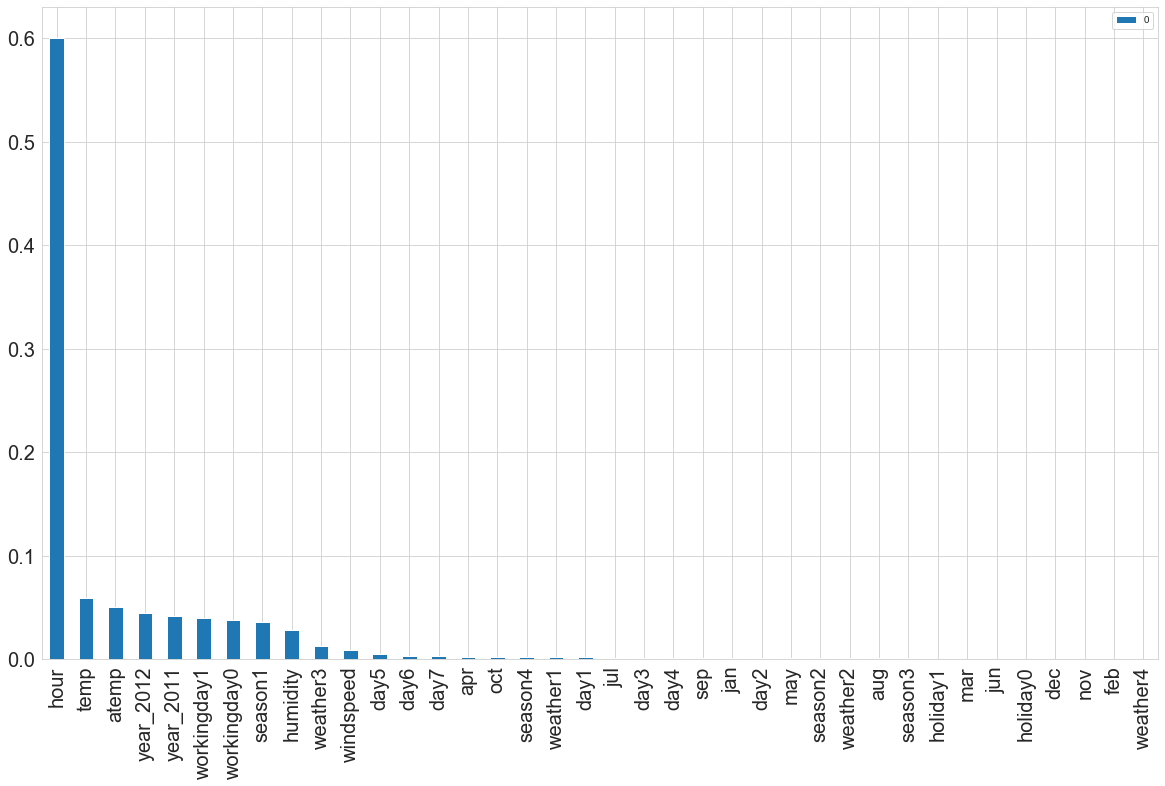

In [452]:
feature_df = pd.DataFrame(feature_importances, cols)
feature_df = feature_df.sort_values(0,ascending=False)
import seaborn as sns
sns.set_style("whitegrid")
feature_df.plot.bar(figsize=(20, 12), fontsize=20)

Looks like hour, temperature, atemperature, and year are the most important features. 

## XGBoost

In [341]:
try:
    import xgboost
except ImportError as ex:
    print("Error: the xgboost library is not installed.")
    xgboost = None

In [342]:
if xgboost is not None:  # not shown in the book
    xgb_reg = xgboost.XGBRegressor(random_state=42)
    xgb_reg.fit(X_train, y_train)

In [343]:
xgb_pred_train = xgb_reg.predict(X_train)
xgb_pred = xgb_reg.predict(X_val)
#rmse_score(y_val, xgb_pred)
xgb_rmse = sqrt(sklearn.metrics.mean_squared_error(y_val, xgb_pred))
print("xgb_pred", xgb_rmse)

xgb_pred 38.53926789531411


In [ ]:
xgb_pred

In [ ]:
np.savetxt("bike_pred.csv", xgb_pred, delimiter=",")
#Score 1.37398
#Target 0.41 to be top 10%

## Ensemble

In [344]:
from sklearn.ensemble import VotingRegressor

In [356]:
estimators = [('gb', xgb_reg), ('rf', rnd_reg)] #('lr', lin_reg)

In [357]:
voting_reg = VotingRegressor(estimators)

In [358]:
voting_reg.fit(X_train, y_train, None)

VotingRegressor(estimators=[('gb',
                             XGBRegressor(base_score=0.5, booster=None,
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          gpu_id=-1, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=0.300000012,
                                          max_delta_step=0, max_depth=6,
                                          min_child_weight=1, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n_jobs=0,
                                          num_paral...
                                          verbosity=None)),
                            ('rf',
                             RandomForestR

In [359]:
voting_reg.voting = "hard"
voting_pred_train = voting_reg.predict(X_train)
voting_pred = voting_reg.predict(X_val)

In [360]:
rmse = sqrt(sklearn.metrics.mean_squared_error(y_val, voting_pred))
print("voting rmse", rmse)

voting rmse 36.29818646977678


In [350]:
voting_reg.voting = "soft"
voting_pred = voting_reg.predict(X_val)
voting_rmse = sqrt(sklearn.metrics.mean_squared_error(y_val, voting_pred))
print("voting rmse", voting_rmse)

voting rmse 36.16144089974731


## Stacking Ensemble

In [361]:
predictions = np.empty((len(X_train), 4))

predictions[:,0] = tree_pred_train
#predictions[:,1] = lin_pred_train
predictions[:,1] = rnd_pred_train
predictions[:,2] = xgb_pred_train
predictions[:,3] = voting_pred_train

In [362]:
predictions_val = np.empty((len(X_val), 4))

predictions_val[:,0] = tree_pred
#predictions_val[:,1] = lin_pred
predictions_val[:,1] = rnd_pred
predictions_val[:,2] = xgb_pred
predictions_val[:,3] = voting_pred

ValueError: could not broadcast input array from shape (6493) into shape (2178)

In [163]:
rnd_forest_blender = RandomForestRegressor(n_estimators=200, oob_score=True, random_state=42)
rnd_forest_blender.fit(predictions, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=True, random_state=42, verbose=0,
                      warm_start=False)

In [164]:
stack_pred = rnd_forest_blender.predict(predictions_val)

In [165]:
rmse_score(y_val, stack_pred)
stack_rmse = sqrt(sklearn.metrics.mean_squared_error(y_val, stack_pred))

RMSE 65.8625882025248
RMSLE 0.5536923454039586


# Preliminary Results from models

In [160]:
print("tree score", tree_rmse)
print("lin score", lin_rmse)
print("random forest score", rnd_rmse)
print("XGBoost score", xgb_rmse)
print("Voting score", voting_rmse)
print("Stacking score", stack_rmse)

tree score 65.88449906943859
lin score 100.13532474640773
random forest score 48.13885292062262
XGBoost score 45.65426210425302
Voting score 43.668514517109564
Stacking score 65.86178264212319


It looks like Randomforest, XGBoost, and Voting scored the best. I am going to focus my efforts on Random Forest because it is a robust technique that makes it hard to overfit.

# Fine-tune the system

To fine tune model, let's do a random grid search by tweaking the parameters of the random forest. 

In [ ]:
max_features = len(pd.DataFrame(X_train).columns)
print(max_features)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint


param_distribs = {
        'n_estimators': randint(low=50, high=200),
        'max_features': randint(low=25, high=max_features),
        'max_leaf_nodes': randint(low=2000, high=3000),
        'max_depth': randint(low=30, high=100),
        'min_samples_leaf': randint(low=3, high=6)
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=50, cv=5, scoring='neg_mean_squared_log_error', random_state=42)
rnd_search.fit(X_train, y_train)

In [ ]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

Best models are: 
* 0.34907918902293605 {'max_depth': 89, 'max_features': 30, 'max_leaf_nodes': 2854, 'min_samples_leaf': 3, 'n_estimators': 192}
* 0.3680234836282352 {'max_depth': 36, 'max_features': 35, 'max_leaf_nodes': 2337, 'min_samples_leaf': 6, 'n_estimators': 41}
* 0.3464692456530694 {'max_depth': 72, 'max_features': 37, 'max_leaf_nodes': 2035, 'min_samples_leaf': 3, 'n_estimators': 120}
* 0.3467524184090808 {'max_depth': 51, 'max_features': 37, 'max_leaf_nodes': 2747, 'min_samples_leaf': 3, 'n_estimators': 98}
* 0.34791258705546213 {'max_depth': 61, 'max_features': 32, 'max_leaf_nodes': 2232, 'min_samples_leaf': 3, 'n_estimators': 111}
* 0.34714720921514236 {'max_depth': 30, 'max_features': 35, 'max_leaf_nodes': 2987, 'min_samples_leaf': 3, 'n_estimators': 91}

Let's take the median value of these top models
max_depth: 56
max_features: 35
max_leaf nodes: 2500
min_samples_leaf: 3
n_estimators: 100

In [500]:
final_model = RandomForestRegressor(n_estimators=100, max_leaf_nodes=2500, max_features = 35, min_samples_leaf = 3, max_depth = 56, n_jobs=-1)

In [501]:
final_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=56,
                      max_features=35, max_leaf_nodes=2500,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=3, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

In [503]:
final_pred = final_model.predict(X_val)
rmse_score(y_val, final_pred)
np.savetxt("bike_pred.csv", final_pred, delimiter=",")
np.savetxt("bike_pred.csv", y_val, delimiter=",")

RMSE 40.64951598748051
RMSLE 0.3670429825870192


# Making predictions on test set

In [166]:
final_pred = final_model.predict(X_test)

In [167]:
final_pred.shape

(6493,)

In [169]:
np.savetxt("bike_pred.csv", final_pred, delimiter=",")

My final score was 0.43024 and my target was to be in top 20% or better than 0.43304. Mission accomplished. The top score was 0.33756 so not so much better than my model.